# <a id='toc1_'></a>[Model Evaluation](#toc0_)

This notebook contains the code to evaluate the models on the test set.

**Table of contents**<a id='toc0_'></a>    
- [Model Evaluation](#toc1_)    
- [Import libraries](#toc2_)    
- [Import data](#toc3_)    
- [Prepare data for training](#toc4_)    
  - [Neural network data](#toc4_1_)    
  - [Linear model data](#toc4_2_)    
- [Train Neural Network](#toc5_)    
  - [Constant width](#toc5_1_)    
  - [Pyramid](#toc5_2_)    
- [Train linear models](#toc6_)    
  - [OLS](#toc6_1_)    
  - [LASSO](#toc6_2_)    
  - [Naïve](#toc6_3_)    
- [Summarize the results](#toc7_)    
  - [Variable importance](#toc7_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Import libraries](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.compose import ColumnTransformer
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import cm
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
from collections import defaultdict


from libs.models import *
from libs.functions import *

plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 4), 'figure.dpi': 300})

%load_ext autoreload
%autoreload 2

# <a id='toc3_'></a>[Import data](#toc0_)

In [2]:
# read data
df = pd.read_csv('data/data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
omxcb = pd.read_csv('data/omxcb_constit.csv')
omxcb['timestamp'] = pd.to_datetime(omxcb['timestamp'])
# df = df.merge(omxcb[['timestamp', 'ticker']], on=['timestamp','ticker'], how='inner')

# <a id='toc4_'></a>[Prepare data for training](#toc0_)

In [ ]:
# prepare expanding window splits
periods = {
    '21' : '2019-12-31', # 2021 is the test set
    '22' : '2020-12-31', # 2022 is the test set
    '23' : '2021-12-31', # 2023 is the test set
    '24': '2022-12-31' # 2024 is the test set
}

# identify dummy vs. numeric columns
feature_cols = [col for col in df.columns if col not in ['timestamp', 'ticker', 'target']]
nace_cols = [c for c in feature_cols if c.startswith('NACE_')]
dummy_cols = ['divi','divo'] # sin removed
macro_cols = ['discount', 'tms', 'dp', 'ep', 'svar'] # 'bm_macro'

# nummeric cols = cols not in cat and macro cols
numeric_cols = [c for c in feature_cols if c not in dummy_cols and c not in nace_cols and c not in macro_cols]

# feature_cols = numeric_cols + dummy_cols + nace_cols # reorder columns to have numeric first

df_raw = df.copy(deep=True)
df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])

# drop data from 2025
df_raw = df_raw[df_raw['timestamp'] < '2025-01-01']
df_raw = df_raw[df_raw['timestamp'] < '2024-12-31']

In [4]:
C = df[numeric_cols].values         # shape = (n_rows, P_c)
X = df[macro_cols].values           # shape = (n_rows, P_x)

# 1) compute all pairwise products with broadcasting:
#    this gives shape (n_rows, P_c, P_x)
K = C[:,:,None] * X[:,None,:]

# 2) reshape to (n_rows, P_c * P_x)
Z = K.reshape(len(df), -1)

# 3) build the column names in the same order
xc_names = [
    f"{c}_x_{m}"
    for c in numeric_cols
    for m in macro_cols
]

# 4) wrap back into a DataFrame
df_xc = pd.DataFrame(Z, columns=xc_names, index=df.index)

feature_cols = numeric_cols + xc_names + dummy_cols + nace_cols
numeric_cols = numeric_cols + xc_names
cat_cols = dummy_cols + nace_cols
df_z = df_raw.merge(df_xc, left_index=True, right_index=True)
# drop macro_cols
df_z = df_z.drop(columns=macro_cols)
# sort columns by feature_cols
df_norm = df_z[['timestamp', 'ticker', 'target'] + feature_cols]

y_values = df_norm['target'].values.astype('float32')


## <a id='toc4_1_'></a>[Neural network data](#toc0_)
Including a validation set

In [5]:
# prepare containers
X_train, X_val, X_test = {}, {}, {}
y_train, y_val, y_test = {}, {}, {}
preprocessors = {}
y_scalers = {}

for y, period in periods.items():
    period = pd.to_datetime(period)

    # split masks
    tr_mask = df_norm['timestamp'] < period
    va_mask = (df_norm['timestamp'] >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=1) < period)
    te_mask = (df_norm['timestamp'] - pd.DateOffset(years=1) >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=2) < period)

    # extract raw feature DataFrames
    X_tr_df = df_norm.loc[tr_mask, feature_cols].copy()
    X_va_df = df_norm.loc[va_mask, feature_cols].copy()
    X_te_df = df_norm.loc[te_mask, feature_cols].copy()
    y_tr    = y_values[tr_mask]
    y_va    = y_values[va_mask]
    y_te    = y_values[te_mask]

    # compute winsorization bounds on train
    lower = X_tr_df[numeric_cols].quantile(0.01)
    upper = X_tr_df[numeric_cols].quantile(0.99)

    # apply clipping to train, val, test
    X_tr_df[numeric_cols] = X_tr_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)
    X_va_df[numeric_cols] = X_va_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)
    X_te_df[numeric_cols] = X_te_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)

    # now fit scaler on numeric only
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', 'passthrough',  cat_cols)
    ])
    preprocessor.fit(X_tr_df)
    preprocessors[y] = preprocessor

    # transform all splits
    X_train[y] = preprocessor.transform(X_tr_df).astype('float32')
    X_val[y]   = preprocessor.transform(X_va_df).astype('float32')
    X_test[y]  = preprocessor.transform(X_te_df).astype('float32')

    # fit standard scaler on y values
    y_scaler = StandardScaler()
    y_scaler.fit(y_tr.reshape(-1, 1))
    y_scalers[y] = y_scaler
    y_tr = y_scaler.transform(y_tr.reshape(-1, 1)).flatten()
    y_va = y_scaler.transform(y_va.reshape(-1, 1)).flatten()
    y_te = y_scaler.transform(y_te.reshape(-1, 1)).flatten()

    # store targets as before
    y_train[y] = y_tr.reshape(-1, 1)
    y_val[y]   = y_va.reshape(-1, 1)
    y_test[y]  = y_te.reshape(-1, 1)


## <a id='toc4_2_'></a>[Linear model data](#toc0_)
Excluding the validation set

In [6]:

Xlin_train, Xlin_test = {}, {}
ylin_train, ylin_test = {}, {}
preprocessors_lin = {}

cat_cols_lin = cat_cols + ['const']
feature_cols_lin = feature_cols + ['const']

for y, period in periods.items():
    period = pd.to_datetime(period)
    tr_mask = df_norm['timestamp']- pd.DateOffset(years=1) < period
    te_mask = (df_norm['timestamp'] - pd.DateOffset(years=1) >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=2) < period)

    # extract feature DataFrames
    X_tr_df = df_norm.loc[tr_mask, feature_cols]
    X_te_df = df_norm.loc[te_mask, feature_cols]
    y_tr = y_values[tr_mask]
    y_te = y_values[te_mask]

    # add constant column for linear regression
    X_tr_df['const'] = 1
    X_te_df['const'] = 1

    # compute winsorization bounds on train
    lower = X_tr_df[numeric_cols].quantile(0.01)
    upper = X_tr_df[numeric_cols].quantile(0.99)

    # apply clipping to train, test
    X_tr_df[numeric_cols] = X_tr_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)
    X_te_df[numeric_cols] = X_te_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)

    # fit scaler only on training set
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', 'passthrough', cat_cols_lin)
    ])
    preprocessor.fit(X_tr_df)
    preprocessors_lin[y] = preprocessor

    # ttransform splits
    Xlin_train[y] = preprocessor.transform(X_tr_df).astype('float32')
    Xlin_test[y]  = preprocessor.transform(X_te_df).astype('float32')

    # targets
    ylin_train[y] = y_tr
    ylin_test[y]  = y_te

# <a id='toc5_'></a>[Train Neural Network](#toc0_)

## <a id='toc5_1_'></a>[Constant width](#toc0_)

In [ ]:
# moving to metal or CUDA GPU if available
device = torch.device(("cuda" if torch.cuda.is_available() 
                       else "mps" if torch.backends.mps.is_available() 
                       else "cpu"))
print("Using device:", device)

# general hyperparameters
hidden_depth = 4 # only hidden, excluding in- and output layers
hidden_width = 16 # int for all being equal width; list for different widths
learning_rate = 1e-4
activation_fun = nn.ReLU # nn.ReLU nn.Tanh nn.Sigmoid nn.LeakyReLU

# general critereon and regularization parameters
criterion = nn.MSELoss() # nn.HuberLoss()
lambda_l1 = 1e-5 # 1e-3 # l1 regularization
lambda_l2 = 1e-4 # 1e-4 # l2 regularization
dropout = 0.0

# general parmeters
patience = 25
print_freq = 250
epochs = 250
batch_size = 4096

n_runs = 5 # number of runs for each model to average over


Using device: mps


In [8]:
best_models = {}
history   = {}
mlp_pred  = {}

for y, period in periods.items():
    print(f"\n=== Year {y}: running {n_runs} restarts ===")
    all_run_preds = []

    for run in range(n_runs):
        # set random seed for reproducibility (change for each run)
        seed = 42 + run
        np.random.seed(seed)
        torch.manual_seed(seed)
        print(f"Run {run+1}/{n_runs}, seed={seed}")

        # instantiate a fresh model & optimizer
        input_dim = X_train[y].shape[1]
        model = MLPModel(input_dim,
                         depth=hidden_depth,
                         width=hidden_width,
                         dropout=dropout,
                         activation=activation_fun).to(device)
        optimizer = torch.optim.Adam(model.parameters(),
                                      lr=learning_rate)


        # wrap datasets
        train_ds = MLPdataset(X_train[y], y_train[y])
        val_ds   = MLPdataset(X_val[y],   y_val[y])

        # train
        trained_model, hist = train_mlp(train_ds,
                                        val_ds,
                                        model,
                                        criterion,
                                        epochs,
                                        patience,
                                        print_freq,
                                        device,
                                        optimizer=optimizer,
                                        lambda_l1=lambda_l1,
                                        lambda_l2=lambda_l2,
                                        batch_size=batch_size,
                                        shuffle_train=True,
                                        shuffle_val=False,
                                        save_path=f'models/mlp_y{y}_l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}.pth'
                                        )

        # predict on test set
        preds = predict_mlp(trained_model,
                            X_test[y],
                            y_test=y_test[y],
                            scaler= y_scalers[y],
                            batch_size=batch_size,
                            device=device)
        all_run_preds.append(preds)

        # optionally store the last run’s model & history
        best_models[(y, run)] = trained_model
        history[(y, run)]     = hist

    # stack (n_runs, n_samples) average over axis=0
    all_run_preds = np.stack(all_run_preds, axis=0)
    mlp_pred[y]   = np.mean(all_run_preds, axis=0)

    print(f"Averaged predictions for year {y} computed.")


=== Year 21: running 5 restarts ===
Run 1/5, seed=42
Early stopping at epoch 26
Best val loss: 1.13553E+00
Model saved to models/mlp_y21_l10.0001_l20.001_drop0.0_lr0.0001_w16_d4_run1.pth
Run 2/5, seed=43
Early stopping at epoch 199
Best val loss: 1.11750E+00
Model saved to models/mlp_y21_l10.0001_l20.001_drop0.0_lr0.0001_w16_d4_run2.pth
Run 3/5, seed=44
Early stopping at epoch 26
Best val loss: 1.13738E+00
Model saved to models/mlp_y21_l10.0001_l20.001_drop0.0_lr0.0001_w16_d4_run3.pth
Run 4/5, seed=45
Early stopping at epoch 26
Best val loss: 1.13541E+00
Model saved to models/mlp_y21_l10.0001_l20.001_drop0.0_lr0.0001_w16_d4_run4.pth
Run 5/5, seed=46
Early stopping at epoch 191
Best val loss: 1.12047E+00
Model saved to models/mlp_y21_l10.0001_l20.001_drop0.0_lr0.0001_w16_d4_run5.pth
Averaged predictions for year 21 computed.

=== Year 22: running 5 restarts ===
Run 1/5, seed=42
Early stopping at epoch 31
Best val loss: 7.07095E-01
Model saved to models/mlp_y22_l10.0001_l20.001_drop0.0_

## <a id='toc5_2_'></a>[Pyramid](#toc0_)

In [9]:
# training model with most data on multiple parameters
hidden_depth_pyr = None
hidden_width_pyr = [32, 16, 8]

In [10]:
best_models_pyr = {}
history_pyr   = {}
mlp_pred_pyr  = {}

for y, period in periods.items():
    print(f"\n=== Year {y}: running {n_runs} restarts ===")
    all_run_preds = []

    for run in range(n_runs):
        # set random seed for reproducibility (change for each run)
        seed = 42 + run
        np.random.seed(seed)
        torch.manual_seed(seed)
        print(f"Run {run+1}/{n_runs}, seed={seed}")

        # instantiate a fresh model & optimizer
        input_dim = X_train[y].shape[1]
        model = MLPModel(input_dim,
                         depth=len(hidden_width_pyr),
                         width=hidden_width_pyr,
                         dropout=dropout,
                         activation=activation_fun).to(device)
        optimizer = torch.optim.Adam(model.parameters(),
                                      lr=learning_rate)


        # wrap datasets
        train_ds = MLPdataset(X_train[y], y_train[y])
        val_ds   = MLPdataset(X_val[y],   y_val[y])

        # train
        trained_model, hist = train_mlp(train_ds,
                                        val_ds,
                                        model,
                                        criterion,
                                        epochs,
                                        patience,
                                        print_freq,
                                        device,
                                        optimizer=optimizer,
                                        lambda_l1=lambda_l1,
                                        lambda_l2=lambda_l2,
                                        batch_size=batch_size,
                                        shuffle_train=True,
                                        shuffle_val=False,
                                        save_path=f'models/mlp_y{y}_l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}.pth'
                                        )

        # predict on test set
        preds = predict_mlp(trained_model,
                            X_test[y],
                            y_test=y_test[y],
                            scaler= y_scalers[y], # preprocessors[y] if hasattr(preprocessors[y], 'inverse_transform') else None,
                            batch_size=batch_size,
                            device=device)
        all_run_preds.append(preds)

        # optionally store the last run’s model & history
        best_models_pyr[(y, run)] = trained_model
        history_pyr[(y, run)]     = hist

    # stack (n_runs, n_samples) average over axis=0
    all_run_preds = np.stack(all_run_preds, axis=0)
    mlp_pred_pyr[y] = np.mean(all_run_preds, axis=0)

    print(f"Averaged predictions for year {y} computed.")


=== Year 21: running 5 restarts ===
Run 1/5, seed=42
Early stopping at epoch 165
Best val loss: 1.11997E+00
Model saved to models/mlp_y21_l10.0001_l20.001_drop0.0_lr0.0001_w16_d4_run1.pth
Run 2/5, seed=43
Early stopping at epoch 188
Best val loss: 1.10889E+00
Model saved to models/mlp_y21_l10.0001_l20.001_drop0.0_lr0.0001_w16_d4_run2.pth
Run 3/5, seed=44
Early stopping at epoch 26
Best val loss: 1.13663E+00
Model saved to models/mlp_y21_l10.0001_l20.001_drop0.0_lr0.0001_w16_d4_run3.pth
Run 4/5, seed=45
Epoch 250/250  - Train Loss: 9.15737E-01  - Val Loss: 1.10931E+00
Best val loss: 1.10725E+00
Model saved to models/mlp_y21_l10.0001_l20.001_drop0.0_lr0.0001_w16_d4_run4.pth
Run 5/5, seed=46
Early stopping at epoch 41
Best val loss: 1.13125E+00
Model saved to models/mlp_y21_l10.0001_l20.001_drop0.0_lr0.0001_w16_d4_run5.pth
Averaged predictions for year 21 computed.

=== Year 22: running 5 restarts ===
Run 1/5, seed=42
Early stopping at epoch 63
Best val loss: 7.00273E-01
Model saved to m

# <a id='toc6_'></a>[Train linear models](#toc0_)

## <a id='toc6_1_'></a>[OLS](#toc0_)

In [11]:
# linear model
# estimate the parameters
ols_est = {}
ols_pred = {}
ols_coefs = {}


for y in periods.keys():
    print(f"Estimating OLS for {y}...")
    x_tr = Xlin_train[y]
    y_tr = ylin_train[y]
    x_te = Xlin_test[y]
    y_te = ylin_test[y]


    # estimate the parameters
    ols_est[y] = estimate(y_tr, x_tr)
    # ols_pred_train[y] = ols_est[y]['b_hat'] @ x_tr.T
    ols_pred[y] = ols_est[y]['b_hat'] @ x_te.T
    ols_coefs[y] = ols_est[y]['b_hat']

Estimating OLS for 21...
Estimating OLS for 22...


/Users/johan/Documents/04 Uni/10 Thesis/git/MastersThesis/libs/functions.py:197: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(cov)).reshape(-1, 1)


Estimating OLS for 23...
Estimating OLS for 24...


In [12]:
ols_coefs_df = pd.DataFrame(ols_coefs, index=feature_cols_lin)

## <a id='toc6_2_'></a>[LASSO](#toc0_)

In [13]:
# linear model
# create a grid using numpy.geomspace
penalty_grid = np.geomspace(1e-7, 100, num = 1000)
lasso_est = {}
# lasso_pred_train = {}
lasso_pred = {}
lasso_coefs = {}


with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)
    for y in periods.keys():
        print(f"Estimating LASSO for {y}...")
        x_tr = Xlin_train[y]
        y_tr = ylin_train[y]
        x_te = Xlin_test[y]
        y_te = ylin_test[y]

        # estimate the model using LassoCV
        fit_CV = LassoCV(cv=5, alphas=penalty_grid, max_iter=1000, eps=1e-3, n_jobs=-1).fit(x_tr,y_tr)
        # lasso_pred_train[y] = fit_CV.predict(x_tr)
        lasso_pred[y] = fit_CV.predict(x_te)

        # store the coefficients
        coef = fit_CV.coef_
        lasso_coefs[y] = coef


Estimating LASSO for 21...
Estimating LASSO for 22...
Estimating LASSO for 23...
Estimating LASSO for 24...


In [14]:
lasso_coefs_df = pd.DataFrame(lasso_coefs, index=feature_cols_lin)

## <a id='toc6_3_'></a>[Naïve](#toc0_)

In [15]:
naive_pred = {}

for y in periods.keys():
    # naive prediction is the mean of the training set
    pred = np.mean(ylin_train[y])
    naive_pred[y] = np.full_like(ylin_test[y], pred, dtype=np.float32)

# <a id='toc7_'></a>[Summarize the results](#toc0_)

In [16]:
pred_dfs = []

for y, period in periods.items():
    # rebuild masks
    te_mask = ((df_norm['timestamp'] - pd.DateOffset(years=1) >= period) &
               (df_norm['timestamp'] - pd.DateOffset(years=2) <  period))
    X_te_df = df_norm.loc[te_mask, feature_cols]
    idx = X_te_df.index


    pred_dfs.append(pd.DataFrame({
        'period':    y,
        'timestamp': df_norm.loc[idx, 'timestamp'],
        'ticker':    df_norm.loc[idx, 'ticker'],
        'y_true':    df_norm.loc[idx, 'target'].values.astype('float32'),
        'discount':  df.loc[idx, 'discount'].values.astype('float32'),
        'Naïve':  naive_pred[y],
        'OLS':    ols_pred[y].flatten(),
        'LASSO':  lasso_pred[y],
        'MLP':    mlp_pred[y],
        'MLP-Pyr': mlp_pred_pyr[y],
    }, index=idx))

all_preds = pd.concat(pred_dfs).sort_index()

# save predictions
all_preds.to_csv('data/predictions.csv', index=True)

In [17]:
all_preds = pd.read_csv('data/predictions.csv', index_col=0, parse_dates=['timestamp'])
all_preds['period'] = all_preds['period'].astype('string')

metrics_full = {}
results_full = {}
methods = ['Naïve',
           'OLS', 
           'LASSO', 
           'MLP',
           'MLP-Pyr',
           ]
for method in methods:
    for y, period in periods.items():
        y_true = all_preds.loc[all_preds['period'] == y, 'y_true']
        y_pred = all_preds.loc[all_preds['period'] == y, method]
        key = f'{method}{y}'
        results_full[key] = {
            'RMSE': rmse_fun(y_pred, y_true),
            'MAE': mae_fun(y_pred, y_true),
            # 'MADL': madl_fun(y_pred, y_true),
            'AMADL': amadl_fun(y_pred, y_true, delta=0.5)
        }
    key = f'{method}Total'
    results_full[key] = {
        'RMSE': rmse_fun(all_preds[method], all_preds['y_true']),
        'MAE': mae_fun(all_preds[method], all_preds['y_true']),
        # 'MADL': madl_fun(all_preds[method], all_preds['y_true']),
        'AMADL' : amadl_fun(all_preds[method], all_preds['y_true'], delta=0.5)
    }
    
for y in list(periods.keys()) + ['Total']:
    if y != 'Total':
        name = '20' + y
    else:
        name = y
    for metric in ['RMSE',
                   'MAE',
                #    'MADL',
                   'AMADL']:
        key = f'*{metric}*{name}'
        vals = [
            results_full[f'Naïve{y}'][metric],
            results_full[f'OLS{y}'][metric],
            results_full[f'LASSO{y}'][metric],
            results_full[f'MLP{y}'][metric],
            results_full[f'MLP-Pyr{y}'][metric],
        ]
        metrics_full[key] = vals

tab_full = latex_table_grouped(methods,metrics_full)

with open('tabs/prediction_results.tex', 'w') as f:
    f.write(tab_full)
print(tab_full)


\begin{tabular}{clccccc}
\hline\hline \\ [-1.8ex]
 &  & Naïve & OLS & LASSO & MLP & MLP-Pyr \\ 
 \hline 
\multirow[c]{5}{*}{\rotatebox{90}{RMSE}} 
& 2021 & 0.10729 & 0.11654 & 0.10664 & 0.10617 & 0.10584 \\ 
 & 2022 & 0.12309 & 0.15493 & 0.12635 & 0.12480 & 0.12470 \\ 
 & 2023 & 0.10608 & 0.12202 & 0.11306 & 0.10570 & 0.10585 \\ 
 & 2024 & 0.10975 & 0.11566 & 0.11193 & 0.10934 & 0.10947 \\ 
 & Total & 0.11177 & 0.12839 & 0.11471 & 0.11179 & 0.11175 \\ 
\hline\multirow[c]{5}{*}{\rotatebox{90}{MAE}} 
& 2021 & 0.06921 & 0.08429 & 0.07233 & 0.06983 & 0.06987 \\ 
 & 2022 & 0.08553 & 0.10331 & 0.08992 & 0.08780 & 0.08770 \\ 
 & 2023 & 0.06752 & 0.08290 & 0.07387 & 0.06650 & 0.06639 \\ 
 & 2024 & 0.06864 & 0.07542 & 0.07162 & 0.06840 & 0.06820 \\ 
 & Total & 0.07277 & 0.08660 & 0.07697 & 0.07319 & 0.07310 \\ 
\hline\multirow[c]{5}{*}{\rotatebox{90}{AMADL}} 
& 2021 & -0.00444 & -0.00268 & -0.00602 & -0.00469 & -0.00524 \\ 
 & 2022 & 0.01058 & 0.01557 & 0.01525 & 0.01308 & 0.01323 \\ 
 & 2023 &

## <a id='toc7_1_'></a>[Variable importance](#toc0_)

In [18]:
period_order   = list(periods.keys())             # ['21','22','23','24']
run_order      = list(range(n_runs))              # [0,1,2]

imp_by_model_year = defaultdict(list)

# ols and lasso
for y in period_order:
    X_eval, y_eval = Xlin_test[y], ylin_test[y].flatten()

    beta_ols    = ols_coefs_df[y].loc[feature_cols_lin].values
    beta_lasso  = lasso_coefs_df[y].loc[feature_cols_lin].values 

    imp_by_model_year['OLS'].append(
        importance_lin(beta_ols, X_eval, y_eval, const='const', 
                       feature=feature_cols_lin)
    )
    imp_by_model_year['LASSO'].append(
        importance_lin(beta_lasso, X_eval, y_eval, const='const', 
                       feature=feature_cols_lin)
    )

# constant width mlp
for y in period_order:
    X_eval, y_eval = X_test[y], y_test[y].flatten()

    # mean across runs first
    imp_runs = []
    for r in run_order:
        model = best_models[(y, r)]
        imp_runs.append(importance_nn(model, X_eval, y_eval, device))
    imp_by_model_year['MLP'].append( np.mean(imp_runs, axis=0) )

# pyramid model
for y in period_order:
    X_eval, y_eval = X_test[y], y_test[y].flatten()

    imp_runs = []
    for r in run_order:
        model = best_models_pyr[(y, r)]
        imp_runs.append(importance_nn(model, X_eval, y_eval, device))
    imp_by_model_year['MLP-pyr'].append( np.mean(imp_runs, axis=0) )

In [19]:
imp_by_model = {
    m : np.mean(vectors, axis=0)           # arithmetic mean over years
    for m, vectors in imp_by_model_year.items()
}

# build a single DataFrame  (rows = features, cols = models)
imp_df = pd.DataFrame(
    { m : vec for m, vec in imp_by_model.items() },
    index = feature_cols
)

base_names = pd.Series(imp_df.index).map(group_label).values
imp_df_agg = (
    imp_df
      .assign(base = base_names)
      .groupby('base', sort=False)
      .sum()
)

# optional: order rows by overall importance
imp_df_agg = imp_df_agg.loc[
    imp_df_agg.mean(axis=1).sort_values(ascending=False).index
]

In [25]:
fig, ax = plt.subplots(figsize=(1.5*len(imp_df_agg.columns),
                                0.2*len(imp_df_agg)))

im = ax.imshow(imp_df_agg.values, aspect='auto', cmap='Blues', vmin=0, vmax=0.05)
ax.set_xticks(np.arange(len(imp_df_agg.columns)))
ax.set_xticklabels(imp_df_agg.columns, ha='center')
ax.set_yticks(np.arange(len(imp_df_agg.index)))
ax.set_yticklabels(imp_df_agg.index, fontsize=10)

# cbar = fig.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
# cbar.ax.set_ylabel("Normalised $\Delta$MSE",
#                    rotation=-90, va='bottom')

fig.tight_layout()
plt.savefig('figs/variable_importance.png', bbox_inches='tight')
# plt.show()
plt.close(fig)

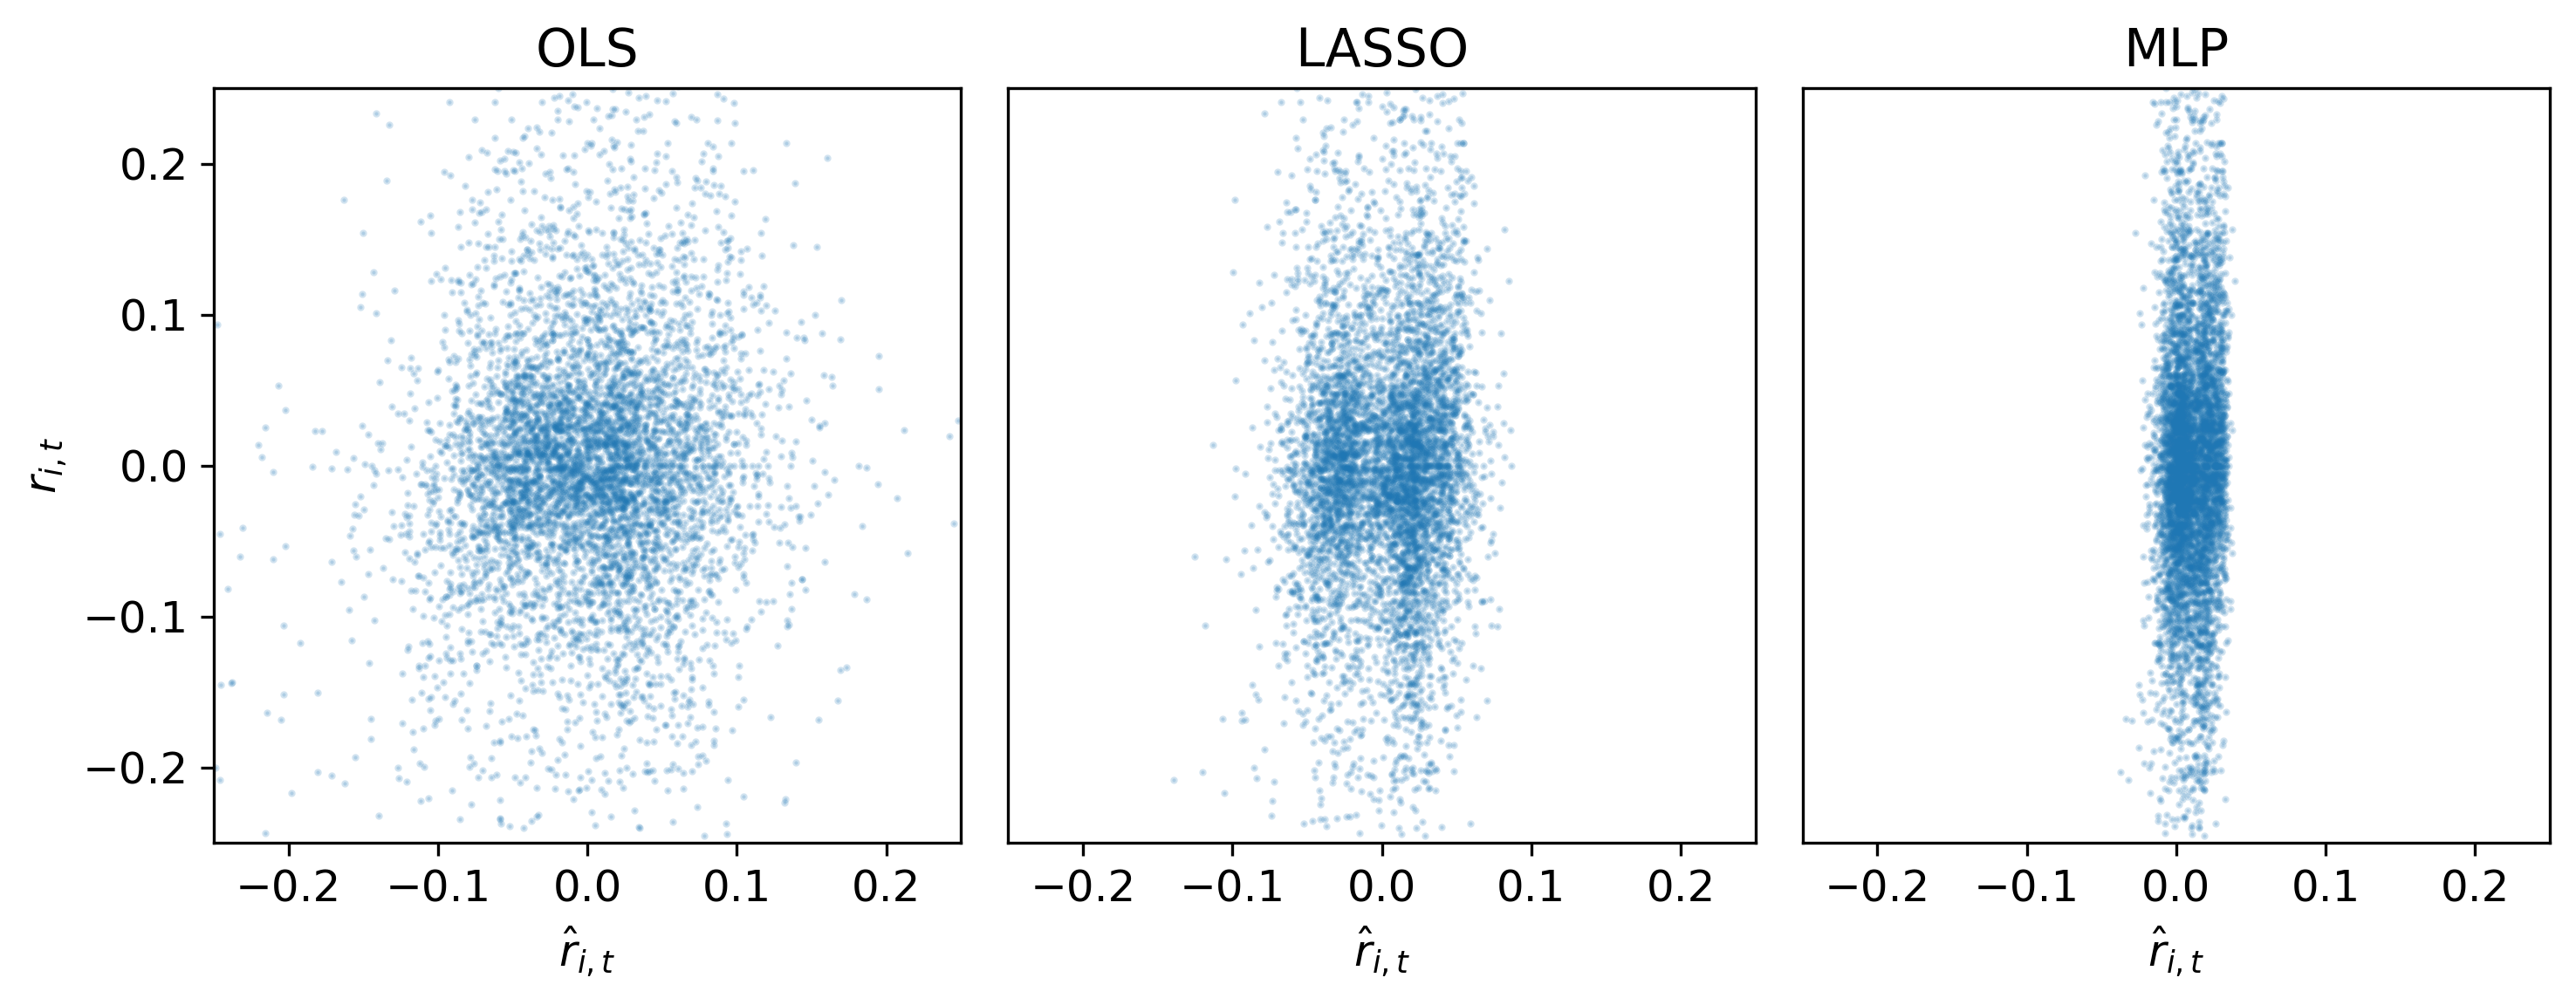

In [21]:
# plot y_true vs. y_pred in scatter
y_min, y_max = -0.25, 0.25

plt.subplot(1,3,1)
plt.scatter(all_preds['OLS'], all_preds['y_true'], alpha=0.2, s=1)
plt.ylabel('$r_{i,t}$')
plt.xlabel('$\hat{r}_{i,t}$')
# plt.yticks(np.arange(-0.3, 0.3, 0.1), fontsize=14)
plt.ylim(y_min, y_max)
plt.xlim(y_min, y_max)
plt.title('OLS')

plt.subplot(1,3,2)
plt.scatter(all_preds['LASSO'], all_preds['y_true'], alpha=0.2, s=1)
plt.xlabel('$\hat{r}_{i,t}$')
plt.ylim(y_min, y_max)
plt.xlim(y_min, y_max)
plt.yticks([])    
plt.title('LASSO')

plt.subplot(1,3,3)
plt.scatter(all_preds['MLP'], all_preds['y_true'], alpha=0.2, s=1)
plt.xlabel('$\hat{r}_{i,t}$')
plt.ylim(y_min, y_max)
plt.xlim(y_min, y_max)
plt.yticks([])    
plt.title('MLP')
plt.tight_layout()
# plt.savefig('figs/y_true_vs_y_pred.png', dpi=300)
plt.show()
plt.close()


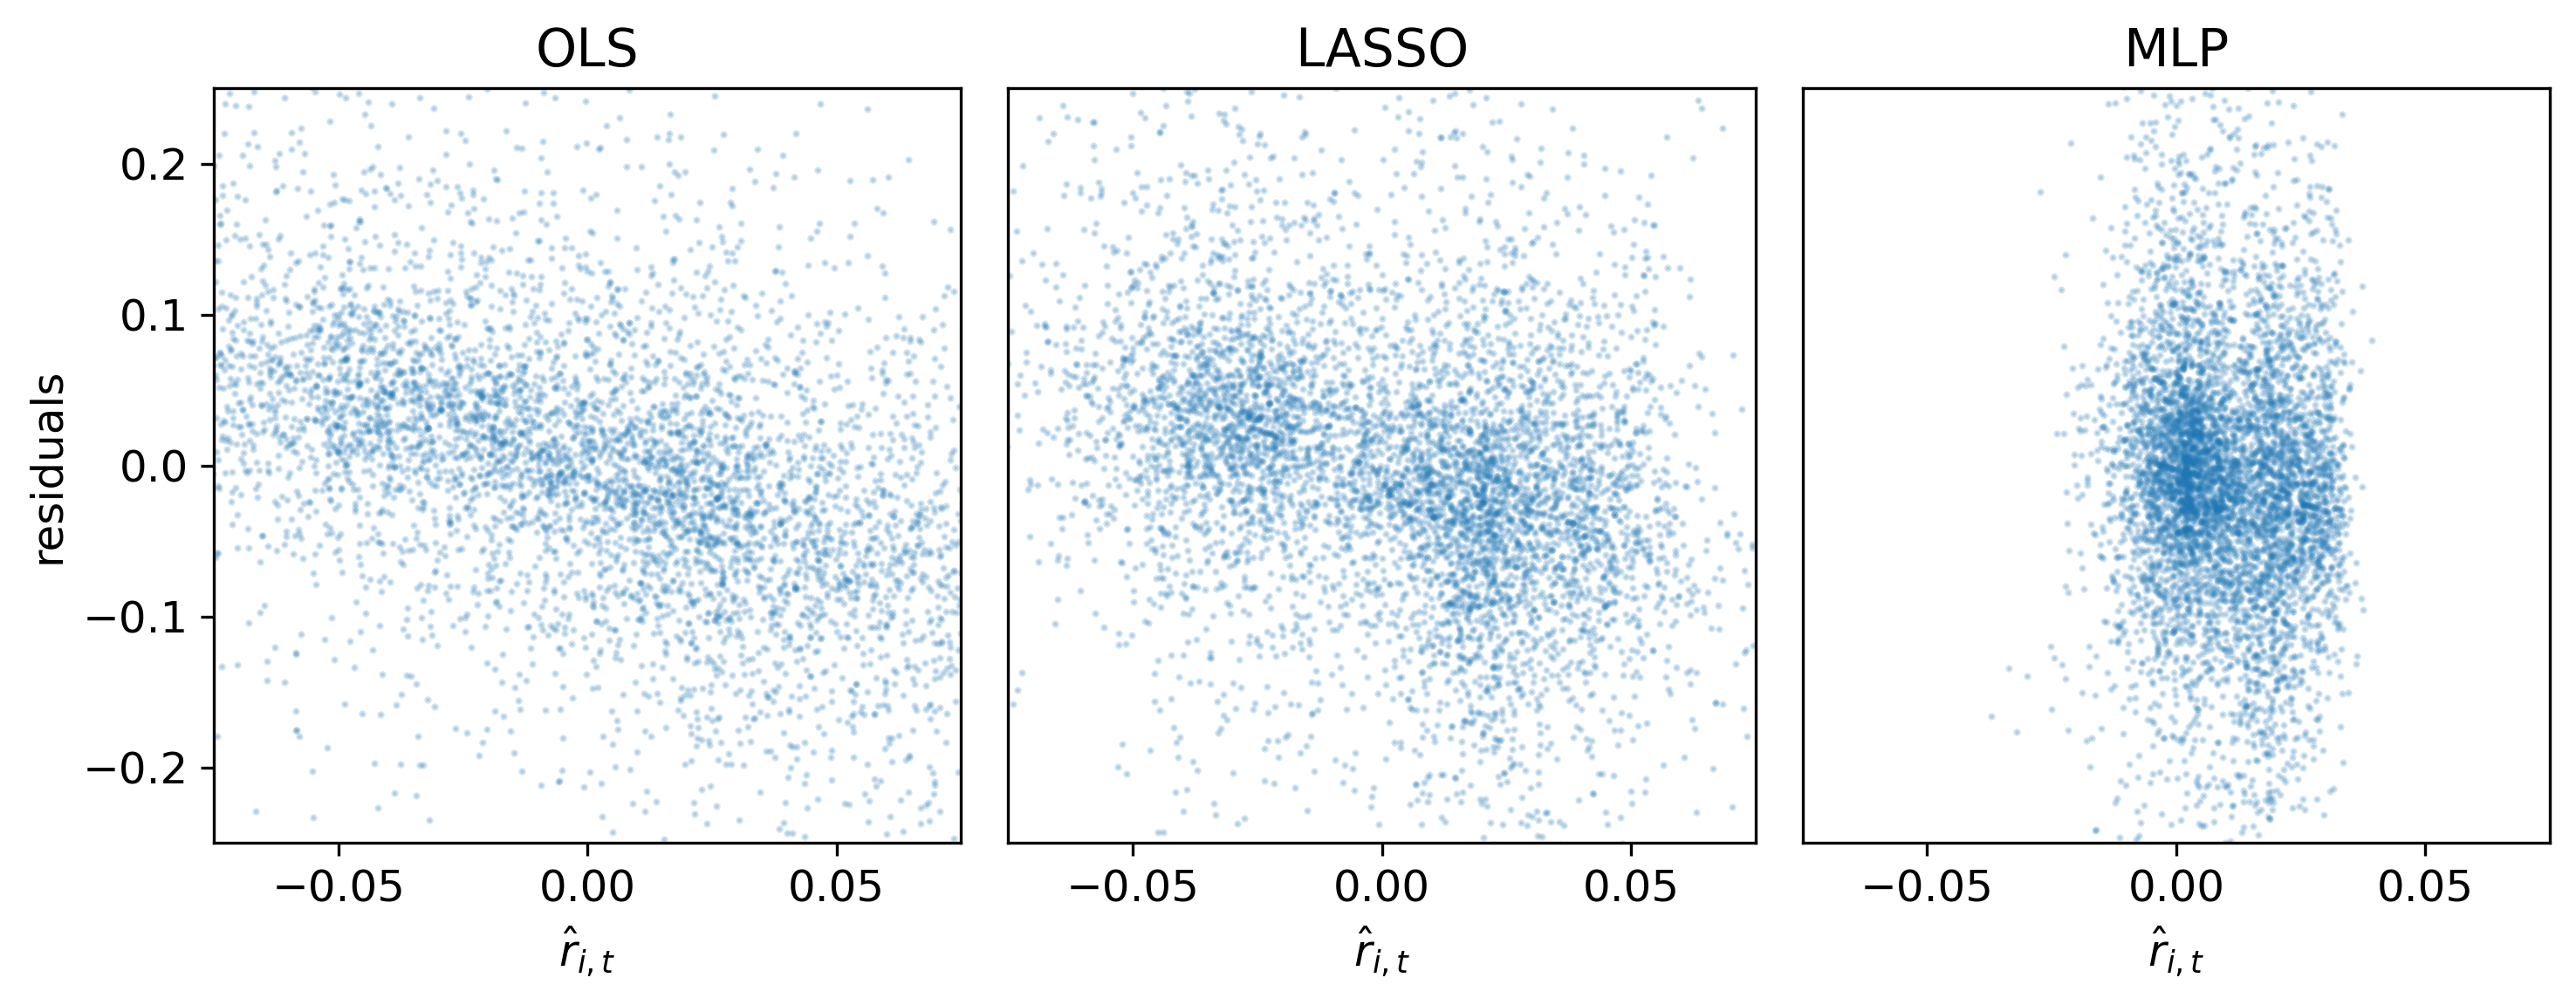

In [22]:
# plot y_true vs. y_pred in scatter
y_min, y_max = -0.25, 0.25

plt.subplot(1,3,1)
plt.scatter(all_preds['OLS'], all_preds['y_true']-all_preds['OLS'], alpha=0.2, s=1)
plt.xlabel('$\hat{r}_{i,t}$')
plt.ylabel('residuals')
# plt.yticks(np.arange(-0.3, 0.3, 0.1), fontsize=14)
plt.ylim(y_min, y_max)
plt.xlim(-0.075, 0.075)
plt.title('OLS')

plt.subplot(1,3,2)
plt.scatter(all_preds['LASSO'], all_preds['y_true']-all_preds['LASSO'], alpha=0.2, s=1)
plt.xlabel('$\hat{r}_{i,t}$')
plt.ylim(y_min, y_max)
plt.xlim(-0.075, 0.075)
plt.yticks([])  
plt.title('LASSO')

plt.subplot(1,3,3)
plt.scatter(all_preds['MLP'], all_preds['y_true']-all_preds['MLP'], alpha=0.2, s=1)
plt.xlabel('$\hat{r}_{i,t}$')
plt.ylim(y_min, y_max)
plt.xlim(-0.075, 0.075)
plt.yticks([])  
plt.title('MLP')
plt.tight_layout()
# plt.savefig('figs/y_pred_vs_error.png', dpi=300)
plt.show()
plt.close()


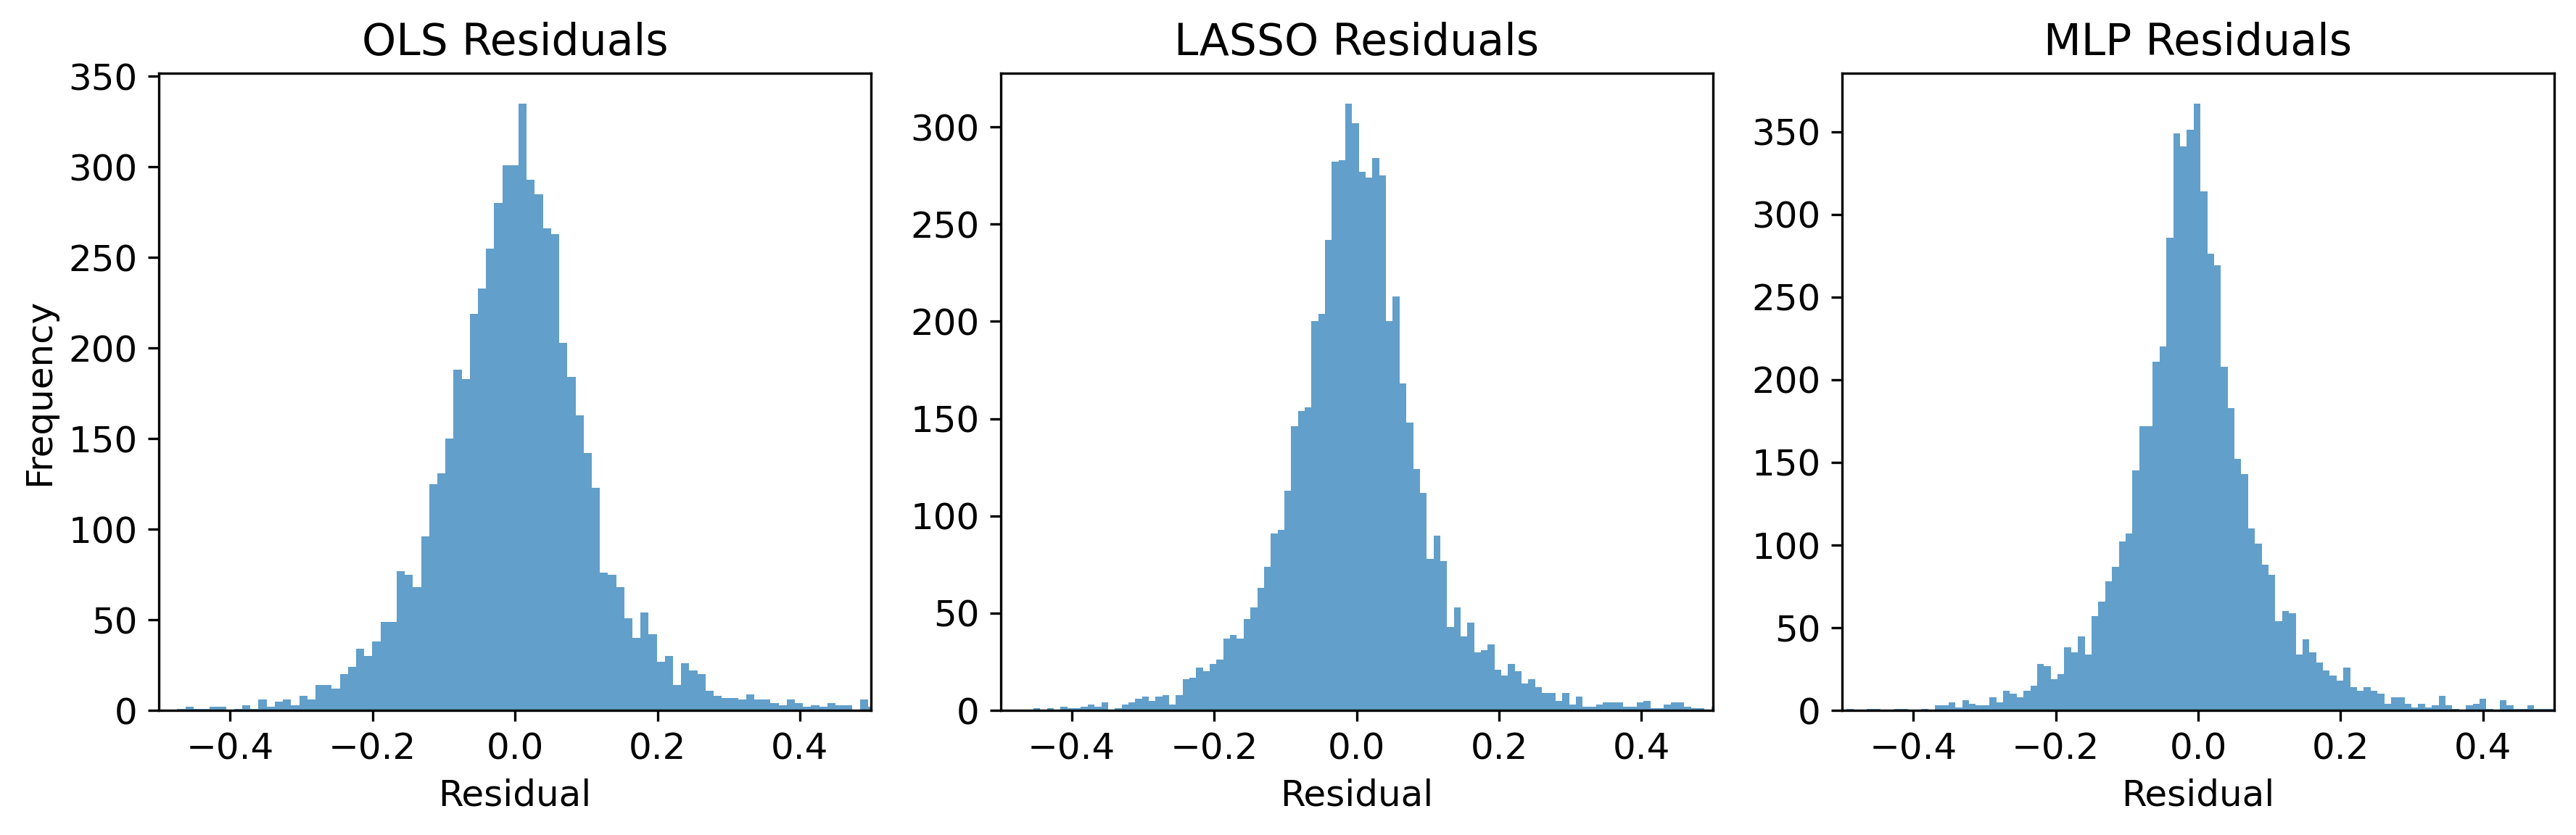

In [23]:
# define plot limits
y_min, y_max = -0.5, 0.5
bins = 200

# Compute residuals
res_ols   = all_preds['y_true'] - all_preds['OLS']
res_lasso = all_preds['y_true'] - all_preds['LASSO']
res_mlp   = all_preds['y_true'] - all_preds['MLP']

# Plot histograms
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(res_ols, bins=bins, alpha=0.7)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('OLS Residuals')
plt.xlim(y_min, y_max)

plt.subplot(1, 3, 2)
plt.hist(res_lasso, bins=bins, alpha=0.7)
plt.xlabel('Residual')
plt.title('LASSO Residuals')
plt.xlim(y_min, y_max)

plt.subplot(1, 3, 3)
plt.hist(res_mlp, bins=bins, alpha=0.7)
plt.xlabel('Residual')
plt.title('MLP Residuals')
plt.xlim(y_min, y_max)

plt.tight_layout()
plt.show()
